# Explainability Metrics for Regression

In [1]:
import sys, os
base_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.insert(0, base_path)

In [2]:
from holisticai.datasets import load_us_crime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from holisticai.explainability import Explainer
from holisticai.metrics.efficacy import regression_efficacy_metrics

## Data Preprocessing

In [3]:
dataset = load_us_crime(return_X_y=False, as_frame=True)
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8.0,NaN,NaN,Lakewoodcity,1.0,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53.0,NaN,NaN,Tukwilacity,1.0,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24.0,NaN,NaN,Aberdeentown,1.0,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34.0,5.0,81440.0,Willingborotownship,1.0,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42.0,95.0,6096.0,Bethlehemtownship,1.0,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [4]:
def preprocess_us_crime_dataset(df, protected_feature):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()
  # Get the protected attribute vectors
  group_a = df_clean[protected_feature].apply(lambda x: x>0.5)
  group_b =  1-group_a
  group_b = group_b.astype('bool')
  # Remove unnecessary columns
  cols = [c for c in df_clean.columns if (not c.startswith('race')) and (not c.startswith('age'))]
  df_clean = df_clean[cols].iloc[:,3:]
  return df_clean, group_a, group_b

In [5]:
df_clean, group_a, group_b = preprocess_us_crime_dataset(df, 'racePctWhite')
X = df_clean.iloc[:,:-1]
y = df_clean.iloc[:,-1]

## Model Training

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split


model = GradientBoostingRegressor() # instantiate model
#model = LinearRegression()
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
regression_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
RMSE,1.396764e-01,0
MAE,9.038879e-02,0
MAPE,1.185104e+12,0
Max Error,7.651164e-01,0
SMAPE,2.367336e-01,0


# Global Explainability Metrics (based on Permutation Feature Importance)

In [7]:
# permutation feature importance
permutation_explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [8]:
permutation_explainer.metrics()

,Value,Reference
Metric,,
Explainability Ease,0.679348,1
Fourth Fifths,0.206522,0
Position Parity,0.061425,1
Rank Alignment,0.759758,1
Spread Divergence,1.321530,-
Spread Ratio,0.707742,0


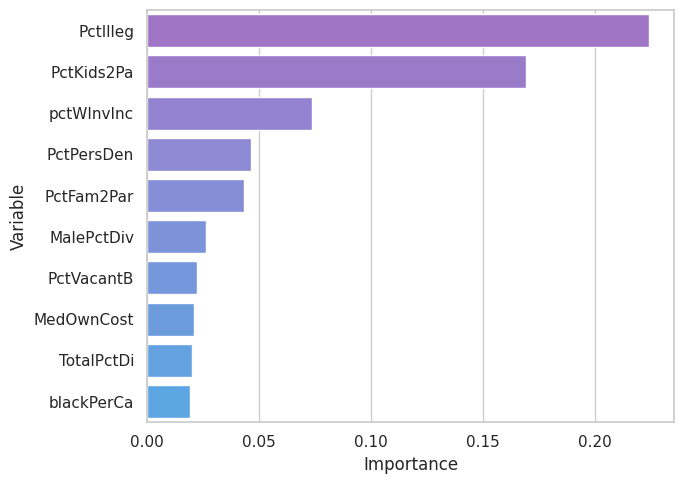

In [9]:
permutation_explainer.bar_plot(max_display=10)

The accumulated feature importance for 11 features is equal 0.6847 < 0.7.


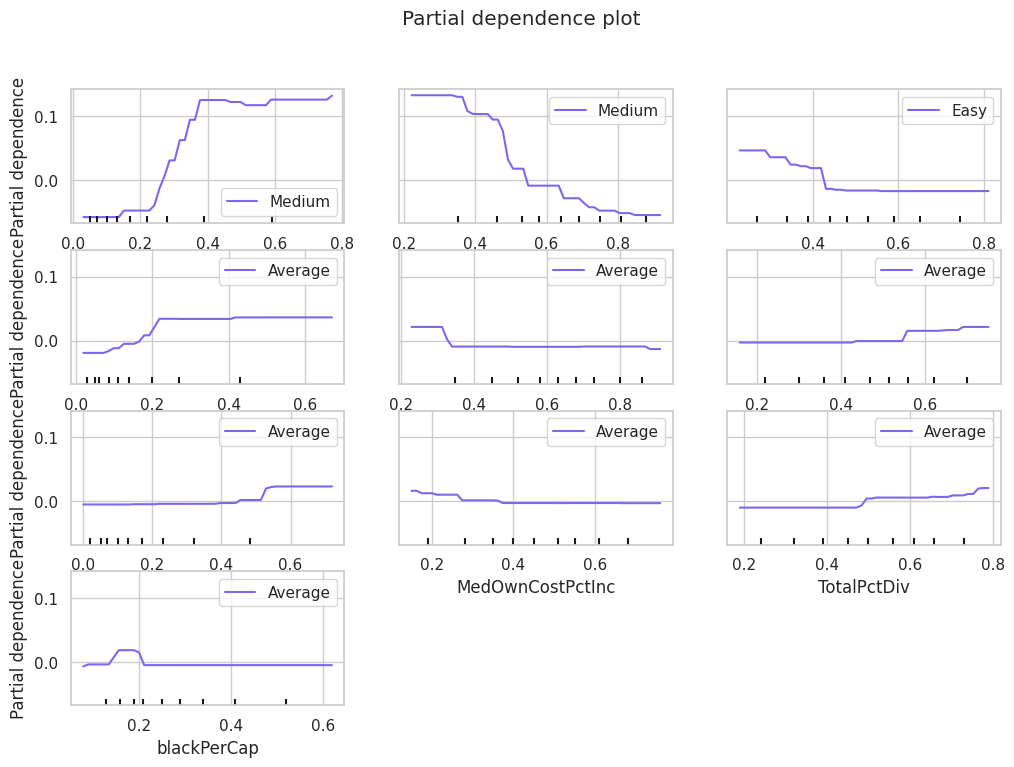

In [10]:
_, ax = plt.subplots(figsize=(12, 8))
permutation_explainer.partial_dependence_plot(last=10, alpha=0.7, ax = ax)

Conditional Feature Importance Metrics

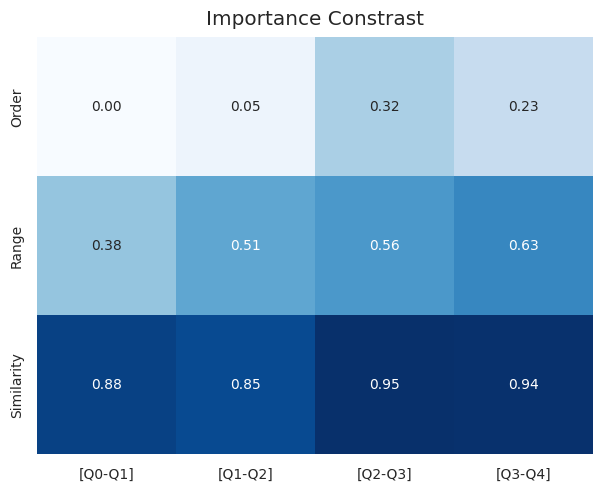

In [11]:
# How change the feature importance for each quantil with respect to the feature importance of the whole model?
permutation_explainer.contrast_visualization(show_connections=False)

In [12]:
permutation_explainer.feature_importance_table(sorted_by='Global', top_n=5)

,Global Importance,[Q0-Q1] Importance,[Q1-Q2] Importance,[Q2-Q3] Importance,[Q3-Q4] Importance
Variable,,,,,
PctIlleg,0.224214,nan,0.066781,0.126036,0.116799
PctKids2Par,0.169332,nan,0.063301,0.092722,0.076164
pctWInvInc,0.073604,0.088453,0.050305,0.026890,0.009787
PctPersDenseHous,0.046580,0.015796,0.014007,0.012161,0.011817
PctFam2Par,0.043439,0.039200,nan,0.030350,0.099208


# Global Explainability metrics (based on Surrogate Model)

In [13]:
# surrogate feature importance
surrogate_explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [14]:
surrogate_explainer.metrics()

,Value,Reference
Metric,,
Explainability Ease,1.000000,1
Fourth Fifths,0.010870,0
Spread Divergence,3.463653,-
Spread Ratio,0.234008,0
Surrogacy Efficacy,0.129917,0


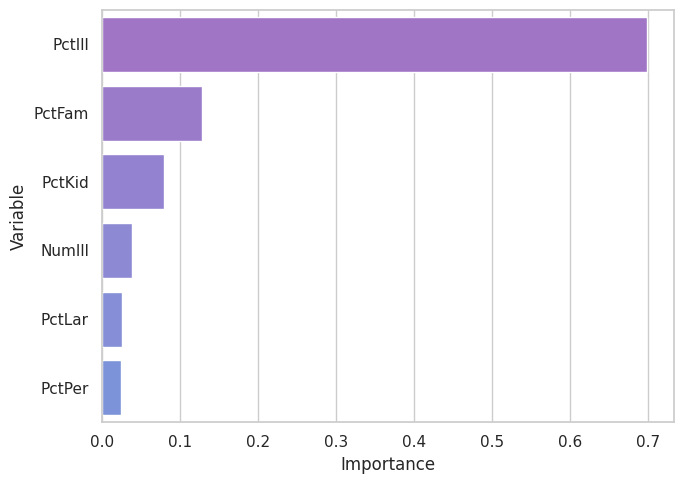

In [15]:
surrogate_explainer.bar_plot(max_display=6)

The accumulated feature importance for 1 features is equal 0.6978 < 0.8.


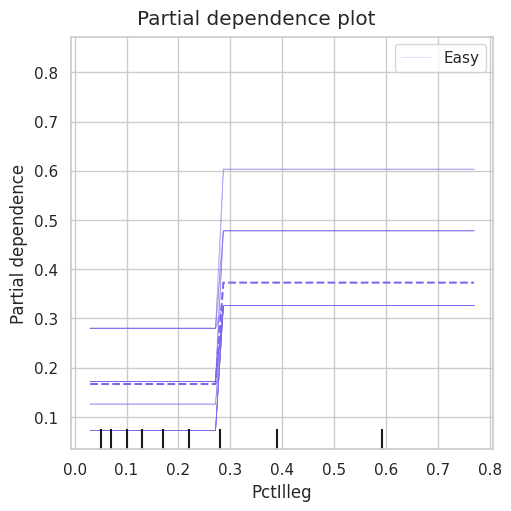

In [16]:
_, ax = plt.subplots(figsize=(5, 5))
surrogate_explainer.partial_dependence_plot(last=1, ax=ax, kind='both')

In [17]:
surrogate_explainer.feature_importance_table(sorted_by='Global', top_n=10)

,Global Importance
Variable,
PctIlleg,0.697821


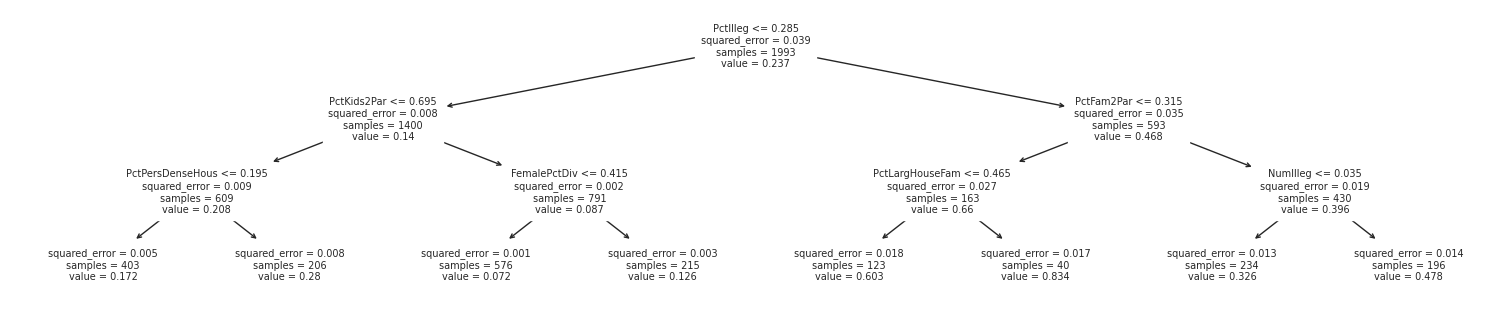

In [18]:
_,ax = plt.subplots(figsize=(15,3))
_ = surrogate_explainer.tree_visualization('sklearn', fontsize=7, ax=ax)

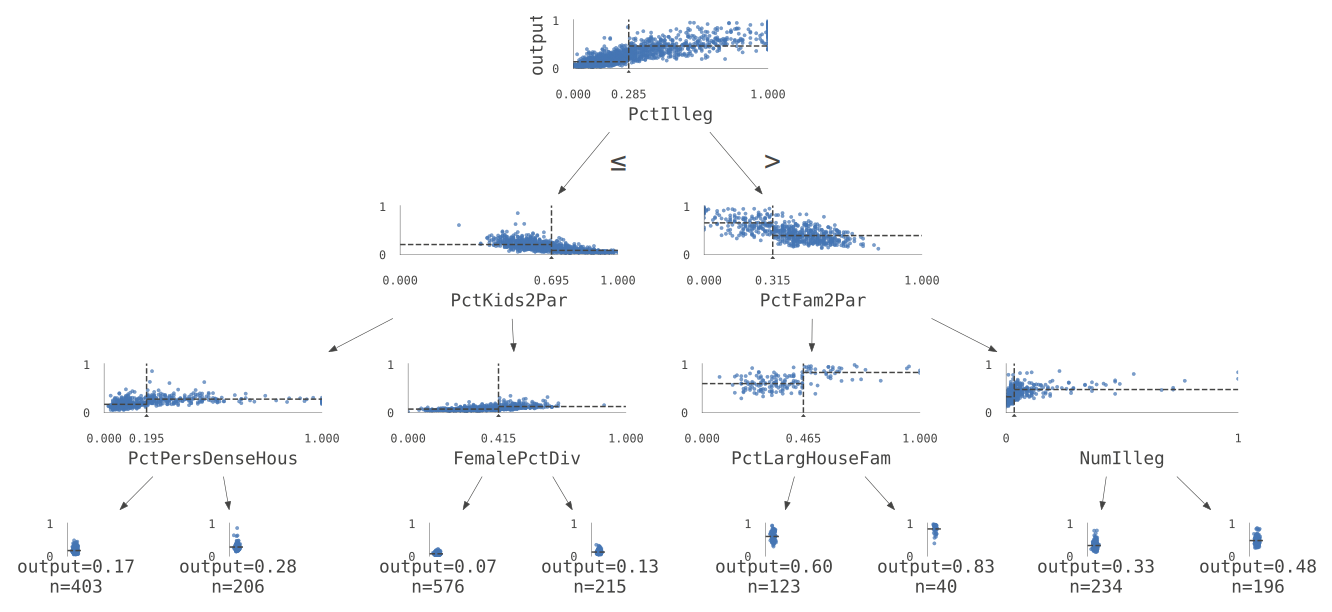

In [19]:
vis = surrogate_explainer.tree_visualization('dtreeviz', scale=2)
vis

# Local Explainability Metrics (based on Lime)

In [20]:
# lime feature importance
lime_explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [21]:
lime_explainer.metrics()

,Value,Reference
Metric,,
Data Stability,0.010347,0
Feature Stability,0.002078,0


In [22]:
lime_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Data Stability,0.010347,0
Data Stability [Q0-Q1],0.005697,0
Data Stability [Q1-Q2],0.006151,0
Data Stability [Q2-Q3],0.008655,0
Data Stability [Q3-Q4],0.012915,0
Feature Stability,0.002078,0
Feature Stability [Q0-Q1],0.003011,0
Feature Stability [Q1-Q2],0.003278,0
Feature Stability [Q2-Q3],0.003910,0


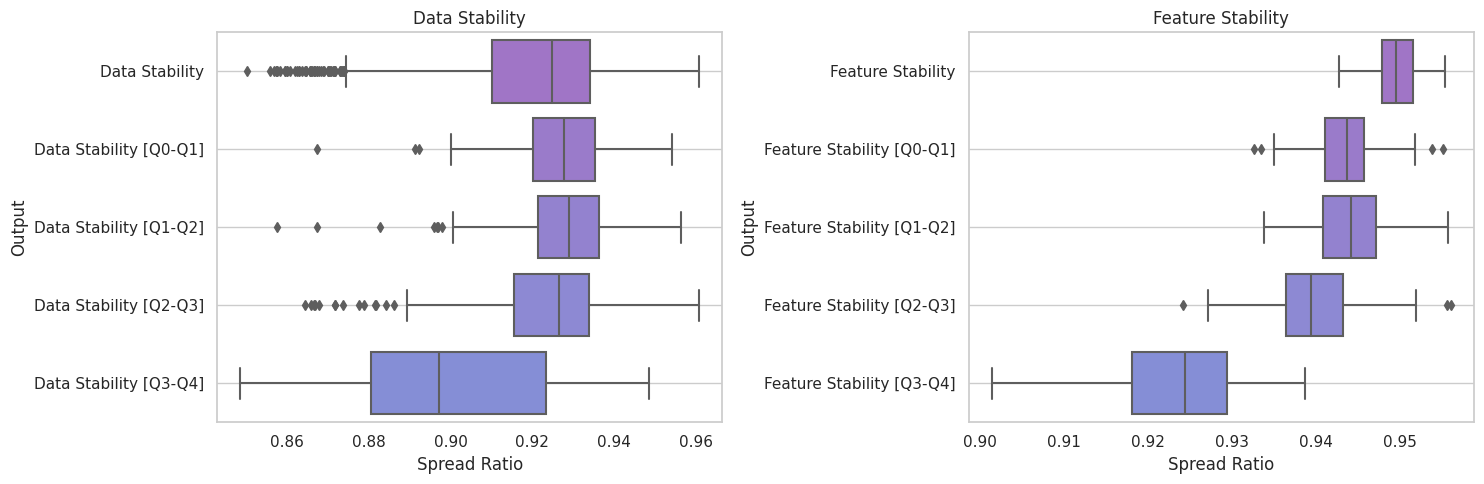

In [23]:
lime_explainer.show_importance_stability()

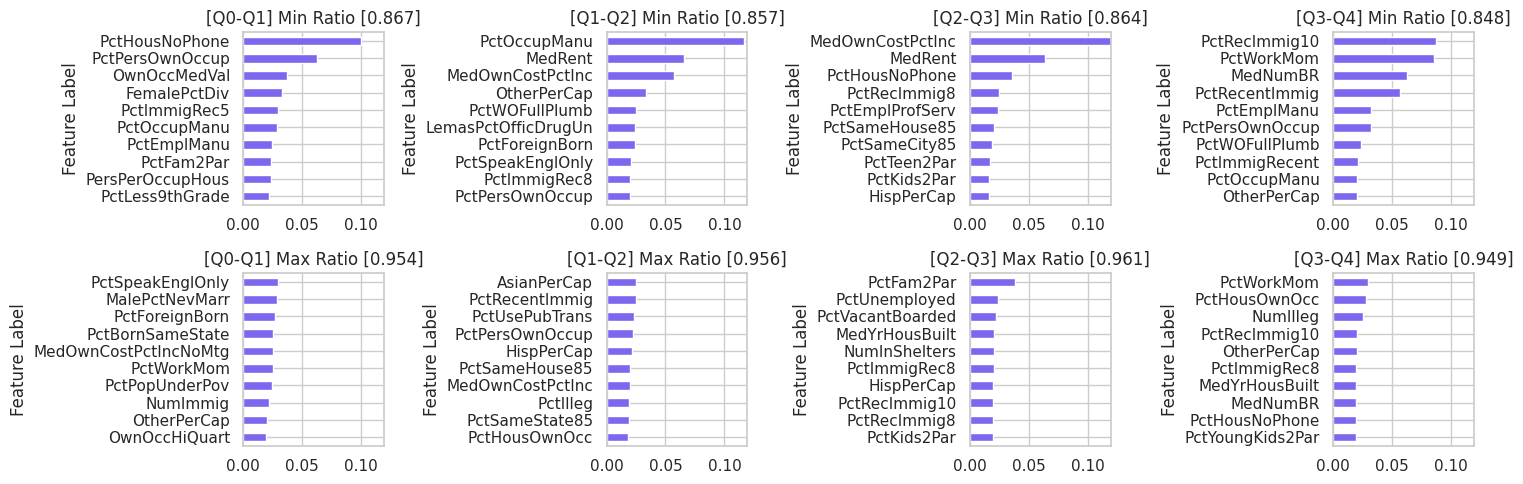

In [24]:
lime_explainer.show_data_stability_boundaries(top_n=10, figsize=(15,5))

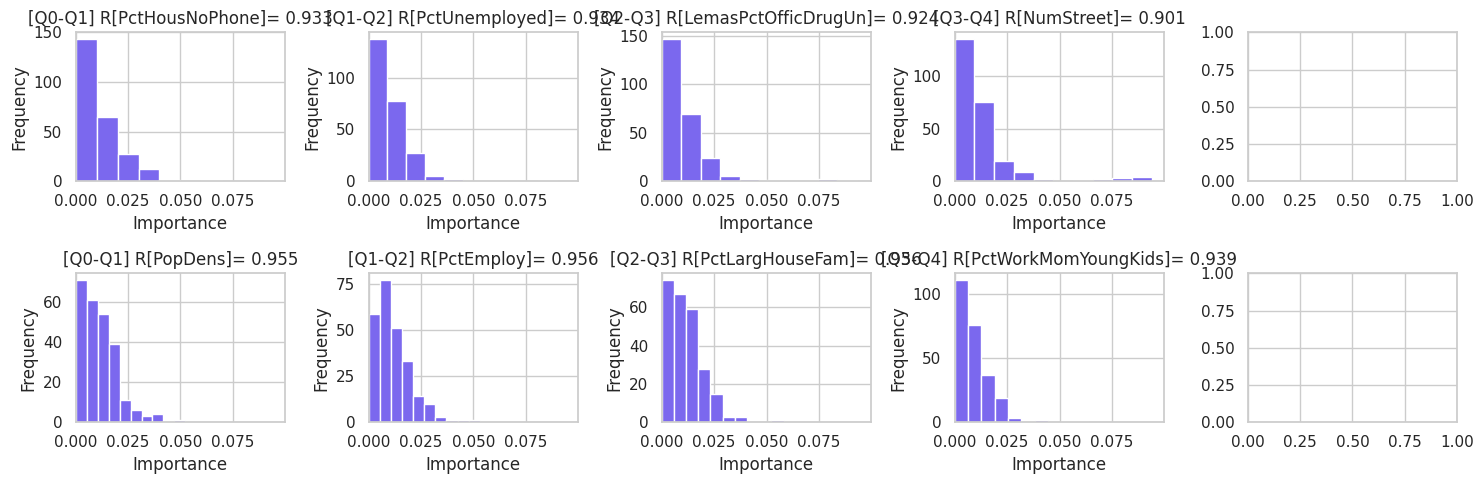

In [25]:
lime_explainer.show_features_stability_boundaries(figsize=(15,5))